# Prosessering av STEM-DPC data

Denne Jupyter Notebooken viser hvordan Scanning Transmission Electron Microscopy - Differential Phase Contrast (STEM-DPC) data kan analyseres. Sammenlignet med analyse av "standard" TEM data som dere så på i forrige Notebook, så er dette mer komplisert på grunn av datastørrelsen: det er veldig enkelt å gå tom for minne, noe som (mest sannsynlig) gjør at datamaskinen deres kræsjer.

### Målet med denne notebooken

- Dere skal kunne prosessere de magnetiske STEM-DPC dataene deres fra TEM-laben
- Bli komfortable med å jobbe med 4-dimensjonelle datasett
- Lære litt enkle verktøy og strategier for å jobbe med store datasett, som ofte er mye større en tilgjengelig minne

### Notebook-planen

- "Åpne" datasettet uten å laste det inn i minnet, "lazily"
- Utforske datasettet, uten å laste det inn i minnet. Via "lazy plotting"
- Redusere datamengden, slik at vi kan laste det inn i minnet
- Bruk center of mass til å finne den magnetiske vektoren i hver probe-posisjon
- Visualisere den magnetiske domenestrukturen i en bildefil

Eksempel på bilde:

<img src="bilder/eksempelbilde_dpc.jpg" width=300 height=300 />

Selve datasettene dere skal se på her er på ca. 8 GB, noe som er ganske smått i "4-D STEM" verdenen: disse kan lett være 100+ GB. Så selv om dere har en datamaskin som takler 8 GB, så anbefaler jeg at dere følger prosedyren for å redusere datastørrelsen.

## Importere biblioteker

Først, plotte-biblioteket. Dette kan enten være `%matplotlib qt` for egne vinduer for plottene, eller `%matplotlib widget` for å få plottene i selve Jupyter Notebooken.

In [1]:
%matplotlib qt

Så importere HyperSpy

In [2]:
import hyperspy.api as hs

## Åpne dataset

Dette gjøres via `hs.load`, som kan åpne en rekke dataformater, spesielt innenfor elektronmikroskopi. Velg et av STEM-DPC datasettene deres, disse skal ha:

- `.hspy` filformat
- Ha filnavn som inneholder noe med: `stem_dpc`, `STEMDPC`, `LowMag`, `Low_Mag`, `lowmag`, `obj_off` eller `OBJOFF`

Siden disse er ganske store, så husk å bruk `lazy=True`. Lag et objekt som heter `s`.

Tips: sjekk docstring for informasjon om hvordan `hs.load` virker.

In [3]:
s = hs.load('stem_dpc_256x256_2msexp_50msfb_polygon.hspy', lazy=True)

Skriv `s` i cellen under, og kjør cellen.

In [4]:
s

<LazyElectronDiffraction2D, title: , dimensions: (256, 256|256, 256)>

Her ser vi at dette er et `LazyElectronDiffraction2D` signal. `Lazy` betyr at dataene er ikke overført til RAM, ergo at dataene ennå bare er på harddisken. I tillegg ser vi at datasettet har `256 x 256` probe-posisjoner, og `256 x 256` detektorposisjoner. Hvert datapunkt er en 16-bit heltall, som gir 2 bytes. Dette gir en datastørrelse på: `256 * 256 * 256 * 256 * 2`, som er ca. 8.6 gigabytes.

En del av dere har nok en datamaskin som kan takle dette, men la oss prøve å redusere datamengden litt.

**VIKTIG:** det er veldig lett å kræsje datamaskinen når man holder på med såpass store datasett. Så pass på at dere har lagret ting dere har åpent.

## Plotting av dataen

`s` er et signal objekt som inneholder mange funksjoner. Et av disse er `plot`, prøv denne. Siden dette er et `lazy` signal, så må HyperSpy kalkulere et navigasjonsbilde ved å hente ut deler (`chunks`) av gangen.

Denne navigeringen kommer (mest sannsynlig) til å være ganske treg, dette fordi alt må leses fra harddisken. Planen nå er å redusere datastørrelsen, slik at vi kan laste alt inn i minnet, men først vil vi utforske datasettet litt for å se hvor mye vi kan redusere datasettet.

Dere får opp to bilder: "navigeringsplot" og "signalplot".

<img src="bilder/nav_og_sig.jpg" width=700 height=700 />

- Tips 1: navigatoren kan gjøres større ved å trykke på `+` knappen på **tastaturet**. Og mindre med å trykke på `-` knappen på **tastaturet**. Dette summerer IKKE flere piksler, men er bare en måte å lettere treffe navigator-markøren.
- Tips 2: dere kan også flytte rundt med pil-tastene.

(Siden folk har litt forskjellige datasett, så er det sannsynlig at ikke alt dette er relevant for alle.)

In [4]:
s.plot()

[########################################] | 100% Completed |  1.3s


Siden vi bare er interessert i senter-disken, så kan vi fjerne alt "tomrommet" (det grønne i bildet her) hvor elektronstrålen ikke er. Ergo: vi beskjærer datasettet, slik at vi bare får de delene vi bryr oss om.

<img src="bilder/01_diffraksjonsbilde_senterdisk.jpg" width=300 height=300 />

Et vanlig problem, er at elektronstrålen flytter seg som funksjon av probe-posisjon. Så vi kan ikke bare beskjære akkurat rundt der den er i en enkeltposisjon, vi må ha litt "ekstra" rom på sidene.

<img src="bilder/01_finn_senter.jpg" width=500 height=500 />

- Plasser navigatoren midt i datasettet, som vist i bildet over.
- Se hva `x` og `y` er i senterpunktet av disken (øverst til høyre i signal plottet)
- Bruk `isig` til å beskjære. Syntaksen er: `s.isig[x0:x1, y0:y1]`, hvor dere kan for eksempel ha +- 50 rundt senterposisjonen. Ergo at det beskjærte området blir 100 x 100 piksler tilsammen.
    * Eksempel: `s.isig[128 - 50 : 128 + 50, 128 - 50 : 128 + 50]`
- Lagre dette som en ny variabel: `s1`. 

Hvis deler av datasettet er "dekket" av tykke deler av prøven, som dere ikke bryr dere om, så bare gjør dette med de områdene som er tynne nok. Hvis du har sånne "uinteressante" områder, så bruk `inav` til å fjerne dem på en tilsvarende måte.

In [5]:
s0 = s.inav[15:225 , 20:220]

In [7]:
s0.plot()

[########################################] | 100% Completed |  1.5s


In [6]:
s1 = s0.isig[74:174, 72:172]

Skriv `s1` i cellen under, og kjør cellen.

In [9]:
s1

<LazyElectronDiffraction2D, title: , dimensions: (210, 200|100, 100)>

Her ser vi at dette er et `LazyElectronDiffraction2D` signal, men med færre detektor-posisjoner! Hvis dere brukt 50 piksler som eksemplet ovenfor, så vil dette nye signalet `s1` bare være 15% av `s` sin størrelse.

For å sjekke hvordan dette ser ut, så bruk: s1.plot()

In [10]:
s1.plot()

[########################################] | 100% Completed |  2.0s


Sjekk at den hele senterdisken ennå er i datasettet, ved å flytte navigatoren til de ytre hjørnene.

Nå er navigeringen mye raskere, fordi vi laster en mye mindre del av datasettet inn i minnet per probeposisjon.

<img src="bilder/02_senter_posisjon.jpg" width=800 height=800 />

Hvis dette ser bra ut så bruk `compute` funksjonen i `s1`.

**VIKTIG:** dette vil laste hele `s1` datasettet inn i minnet, og hvis du ikke har gjort de forrige stegene riktig, så kan det kræsje datamaskinen din!

In [7]:
s1.compute()

[########################################] | 100% Completed | 11.8s


Nå vil plottingen være mye raskere, siden alt er i minnet. Bruk `plot` i `s1`, for å se hvordan prøven og datasettet ser ut.

s1.plot()

In [12]:
s1.plot()

In [16]:
s1.metadata

├── General
│   └── title = 
└── Signal
    ├── binned = False
    └── signal_type = electron_diffraction

## Magnetisk kontrast

Nå som datasettet er litt mer håndterbart, så kan vi prøve å se de magnetiske domenene.

En enkel måte å gjøre dette på, er å bytte om på "navigasjon" og "signal" dimensjonene. Ergo: istedet for at vi endrer på probe-posisjonen, så endrer vi heller på detektorposisjonen.

Kjør: `s1.T.plot()`, og flytt navigatoren rundt senterstrålen. Dette vil se litt rart ut, på grunn av at elektronstrålen flytter på seg, men dere burde kunne se litt magnetisk kontrast på grensen mellom de lyse og mørke områdene.

In [14]:
s1.T.plot()

## Mer avansert analyse

En litt mer avansert måte å analysere dette, er å bruk `center_of_mass` funksjonen i `s1`. Lagre dette som `s1_com`. Dette regner ut hvor senter-posisjonen er for alle probe-posisjonene.

In [8]:
s1_com = s1.center_of_mass()

[########################################] | 100% Completed |  6.4s


Dette gir et `DPCSignal2D`, hvor x- og y-posisjonene er i navigasjonsposisjonene.

Bruk `plot` i `s1_com`. I navigasjons dimensjon så er det x- og y-posisjonen til elektronstrålen, dette kan kobles direkte til det magnetiske feltet i prøven. Bytt mellom x og y med piltastene på tastaturet.

Dette skal ca. se sånn ut:

<img src="bilder/center_of_mass_raw.jpg" width=800 height=800 />

Tips: hvis det er vanskelig å se bruk kontrast-editoren, ved å trykke på `H`-knappen.

In [16]:
s1_com.plot()

Her ser vi at vi har et problem med at senter-strålen har flyttet seg, som gir et "plan" i både x- og y-retningen.

Dette kan korrigeres ved å bruk `correct_ramp` funksjonen i `s1_com`.

Bruk denne, og lagre den som `s1_com_corr`.

In [9]:
s1_com_corr = s1_com.isig[30:175, 30:170].correct_ramp()

Så plot `s1_com_corr`, ved å bruke `get_color_signal().plot()`.

In [10]:
s1_com_corr.get_color_signal().plot()

Dette skal se noe ut som dette:

<img src="bilder/center_of_mass_color.jpg" width=200 height=200 />

Hvis det ser ut som dette (se under), se har `correct_ramp` ikke virket ordentlig. Det magnetiske området som er i midten på y-aksen på figuren under, skal ha mange forskjellige farger.

<img src="bilder/center_of_mass_bad_corrected_ramp.jpg" width=200 height=200 />

I dette tilfellet er det fordi områdene over og under det tynne området er så tykke at center of mass ikke virker særlig bra. Da må disse områdene fjernes ved å bruke `s_com.isig[: y0:y1]`, FØR man kjører `s1_com.correct_ramp`.

Så i dette tilfellet:
```python
s1_com_corr = s1_com.isig[:, 40:190].correct_ramp()
s1_com_corr.get_color_signal().plot()
```
<img src="bilder/center_of_mass_color_corrected_good.jpg" width=300 height=300 />

## Plotting av disse dataene

Nå kan dette kombineres med kunnskapen og koden dere brukte i TEM-bildedata notebooken, og FIB notebooken, til å lage en figur som ligner på den i starten av denne Jupyter Notebooken.

For å få disse fargeplottene i en matplotlib-figur, så først lag en `fig` og en `ax` via matplotlib.

Så bruk `get_color_image_with_indicator` i `s1_com_corr` med `ax=ax`.

In [28]:
s1_com_corr.axes_manager.signal_axes[0].scale = 5/110
s1_com_corr.axes_manager.signal_axes[1].scale = 5/110

In [11]:
import matplotlib.pyplot as plt

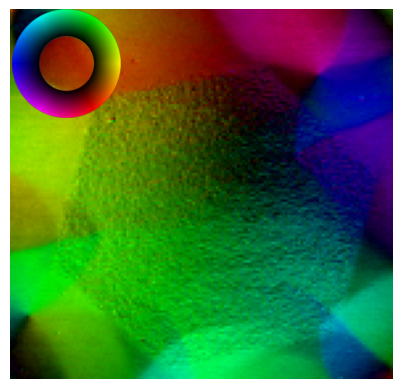

In [35]:
fig, ax = plt.subplots()
#ax.imshow(s1_com_corr.data, extent=s1_com_corr.axes_manager.signal_extent) 
#Det over ga meg feilmelding "Invalid shape (2, 140, 145) for image data" så scalebaren er helt feil.
ax_indicator = fig.add_subplot(321)
fig = s1_com_corr.get_color_image_with_indicator(ax=ax, ax_indicator=ax_indicator)
fig

In [26]:
#fig.savefig("magnestiske_domener_heksagon_uten_scale.jpg", dpi=300)

Tips: posisjonen til fargehjulet kan styres med `ax_indicator` parameteren, se docstringen for mer informasjon.

In [30]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import matplotlib.patheffects as patheffects
fontprops = fm.FontProperties(size=14)

In [36]:
scalebar_kwargs = {'size': 2, 'label': '2 um', 'loc': 4, 'frameon': False, 'color': 'white', 'size_vertical': 0.2, 'label_top': False, 'fontproperties': fontprops}
scalebar0 = AnchoredSizeBar(transform=ax.transData, **scalebar_kwargs)
# Denne legger til et svart omriss rundt scalebar teksten, for å gjøre den lettere å lese
scalebar0.txt_label._text.set_path_effects([patheffects.withStroke(linewidth=2, foreground='black', capstyle="round")])
ax.add_artist(scalebar0)

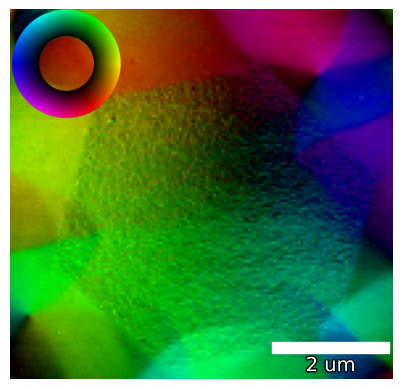

In [37]:
fig

In [38]:
fig.savefig("magnestiske_domener_heksagon.jpg", dpi=300)